# Competitive League of Legends probabilistic model with Bayesian Networks

Enrico Benedetti

Email: enrico.benedetti5@studio.unibo.it

In [1]:
!pip install pgmpy

### Loading dataset
The dataset [[link]](https://www.kaggle.com/datasets/braydenrogowski/league-of-legends-worlds-2021-playin-group-stats) contains match statistics for all games played in the League of Legends Worlds 2021 Play-in Groups.

In [2]:
import pandas as pd
import numpy as np
file_path = 'lol_data.csv'
data = pd.read_csv(file_path)

data.head()

,Team,Player,Opponent,Position,Champion,Kills,Deaths,Assists,Creep Score,Gold Earned,Champion Damage Share,Kill Participation,Wards Placed,Wards Destroyed,Ward Interactions,Dragons For,Dragons Against,Barons For,Barons Against,Result
0,UOL,Boss,GS,Top,Camille,4,5,3,188,11107,0.17,0.78,8,8,16,0,4,0,1,L
1,GS,Crazy,UOL,Top,Gwen,3,1,9,217,12201,0.20,0.52,10,7,17,4,0,1,0,W
2,UOL,Ahahacik,GS,Jungle,Trundle,2,4,5,156,9048,0.15,0.78,8,14,22,0,4,0,1,L
3,GS,Mojito,UOL,Jungle,Talon,5,4,10,194,11234,0.23,0.65,12,8,20,4,0,1,0,W
4,UOL,Nomanz,GS,Mid,Leblanc,1,3,4,216,9245,0.29,0.56,6,9,15,0,4,0,1,L


#### Glossary [(see also this site)](https://primagames.com/featured/lol-slang-popular-league-legends-terms)
- `Position`: determines the role of the player in the team. Can have values `Top`, `Mid`, `Jungle`, `Bot`, `Support`.
- `Creep Score`: The amount of ai-controlled creatures killed by the player. Each one is worth some amount of gold.
- `Gold Earned`: Gold is used to buy items that empower the player.
- `Ward Interactions`: Wards are items that provide vision when placed on the map.
- `KDA`: measure for the amount of `Kills`, `Deaths` and `Assists` of a player.
- `Epic Monsters`: Epic monsters (dragons and baron) provide the whole team power-ups when killed.

### Data preprocessing
For the purpose of simplifying the resulting network, preprocessing is applied.
- some features have been combined into new ones, such as `KDA` and `Epic Monster Advantage`.
- some features from the original dataset have been dropped.
- numerical features have been categorized into three or four bins.

Bin intervals for some features have been chosen arbitrarily by me based on my knowledge of the game. Another approach could have been automatically binning everything based on percentile.

In [3]:
data.describe()

,Kills,Deaths,Assists,Creep Score,Gold Earned,Champion Damage Share,Kill Participation,Wards Placed,Wards Destroyed,Ward Interactions,Dragons For,Dragons Against,Barons For,Barons Against
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,2.709091,2.718182,5.668182,200.340909,11008.159091,0.200000,0.608273,19.454545,8.704545,28.159091,2.090909,2.090909,0.545455,0.545455
std,2.579673,1.747179,3.888149,101.328153,3198.806207,0.095051,0.190404,15.713553,5.101614,18.051857,1.381849,1.381849,0.657050,0.657050
min,0.000000,0.000000,0.000000,14.000000,4714.000000,0.040000,0.000000,3.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,3.000000,156.000000,8691.250000,0.130000,0.500000,10.000000,5.000000,17.000000,1.000000,1.000000,0.000000,0.000000
50%,2.000000,3.000000,5.000000,210.000000,10454.500000,0.205000,0.625000,14.000000,7.000000,22.000000,2.000000,2.000000,0.000000,0.000000
75%,4.000000,4.000000,8.000000,266.250000,13431.750000,0.260000,0.740000,19.000000,12.000000,30.500000,3.250000,3.250000,1.000000,1.000000
max,13.000000,7.000000,19.000000,419.000000,20546.000000,0.470000,1.000000,92.000000,30.000000,112.000000,4.000000,4.000000,2.000000,2.000000


In [4]:
# making combined features
data['KDA'] = (data['Kills'] + data['Assists']) / data['Deaths']

# 'True' if both dragons and barons slain of one team are more than the opponents'
data['Epic Monsters Advantage'] = np.where(np.logical_and(data['Dragons For'] - data['Dragons Against'] > 0, data['Barons For'] - data['Barons Against'] > 0), 'True', 'False')

# binning data
cut_bins = [0, 1, 3, float('inf')]
data['KDA'] = pd.qcut(data['KDA'], q=4, labels=[f'q{k+1}' for k in range(4)])

cut_labels = ['0_low', '1_medium', '2_high']
cut_labels_cs = ['low', 'medium', 'high']
cut_bins = [0, 210, 250, float('inf')]
data['Creep Score'] = pd.cut(data['Creep Score'], bins=cut_bins, labels=cut_labels, include_lowest=True)

cut_labels_gold = ['low', 'medium', 'high']
cut_bins = [0, 9000, 13000, float('inf')]
data['Gold Earned'] = pd.cut(data['Gold Earned'], bins=cut_bins, labels=cut_labels, include_lowest=True)

cut_labels_wards = ['0_low', '1_high']
cut_bins = [0, 30, float('inf')]
data['Ward Interactions'] = pd.cut(data['Ward Interactions'], bins=cut_bins, labels=cut_labels_wards, include_lowest=True)

# drop columns to simplify model
to_drop = ['Kills', 'Deaths', 'Assists', 'Kill Participation', 'Wards Placed', 'Wards Destroyed',
 'Opponent', 'Champion', 'Player', 'Team',
 'Champion Damage Share', 'Dragons For', 'Dragons Against', 'Barons For', 'Barons Against']
data = data.drop(axis='columns', labels=to_drop)

# see the final result of preprocessing
data.head()

,Position,Creep Score,Gold Earned,Ward Interactions,Result,KDA,Epic Monsters Advantage
0,Top,0_low,1_medium,0_low,L,q2,False
1,Top,1_medium,1_medium,0_low,W,q4,True
2,Jungle,0_low,1_medium,0_low,L,q2,False
3,Jungle,0_low,1_medium,0_low,W,q3,True
4,Mid,1_medium,1_medium,0_low,L,q2,False


### Constructing the Bayesian Network structure

When it is difficult to know the causal relations between the variables, there are methods to guess the structure of the Bayesian Network from data.
One approach is Tree Search with the Chow and Liu algorithm. The first result was not convincing to me as a domain expert.

Another approach seemed better because a part of the structure can be fixed and built upon during the search.
The structure estimation is being carried out through Hill Climb search, which is a simple iterative algorithm to find a solution from a local starting point.
The `pgmpy` class for Hill Climb search allows to define constraints for the network structure, so a blacklist has been used to enforce some knowledge, i.e. the fact that in a match, the player `Position` is decided before playing, and that the `Result` is the last thing that happens after the game.

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

Building tree: 100%|██████████| 21/21.0 [00:00<00:00, 3507.92it/s]


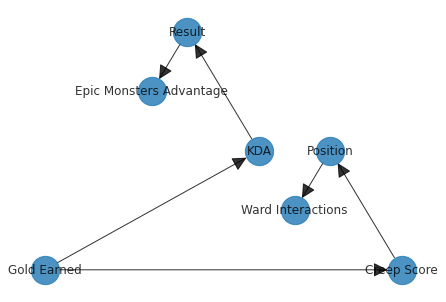

In [6]:
from pgmpy.estimators import TreeSearch
# learn DAG structure from data with Tree Search
est = TreeSearch(data)
dag = est.estimate(estimator_type="chow-liu")
nx.draw_planar(
    dag, with_labels=True, arrowsize=30, node_size=800, alpha=0.8
)
plt.show()
model = dag

In [7]:
from pgmpy.estimators import HillClimbSearch
# learn DAG structure from data with Hill Climb search

# assume the result does not influence the other variables
black_list = [('Result', x) for x in data.columns]
# assume the position is not influenced by other variables
black_list += [(x, 'Position') for x in data.columns]
hc = HillClimbSearch(data)
model = hc.estimate(epsilon=1e-10,max_iter=1000, black_list=black_list)

  1%|          | 10/1000 [00:00<00:39, 25.18it/s]


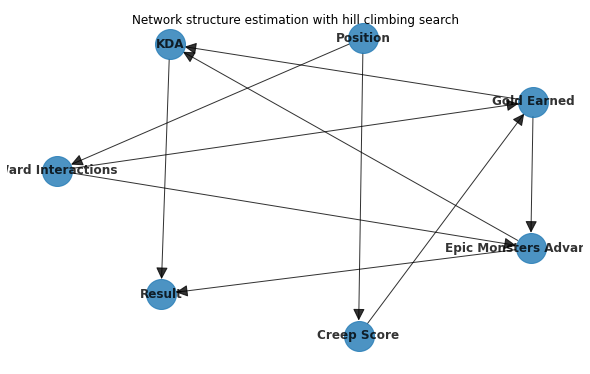

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,5))
fig.suptitle('Network structure estimation with hill climbing search')
nx.draw(
    model, with_labels=True, arrowsize=25, node_size=900, alpha=0.8, font_weight="bold", font_size=12
)
plt.show()

We can look at some conditional independencies for some nodes of the network.

In [9]:
# look at all independencies of all nodes - long output
#print(model.get_independencies())
variables = ['Result', 'KDA']
model.local_independencies(variables)

(Result ⟂ Position, Ward Interactions, Gold Earned, Creep Score | Epic Monsters Advantage, KDA)
(KDA ⟂ Position, Ward Interactions, Creep Score | Epic Monsters Advantage, Gold Earned)

In a Bayesian network, the Markov Blanket of a node includes its parents, children and the other parents of all of its children.
Any variable is conditionally independent of all other variables given its Markov Blanket.

In [10]:
# get the markov blanket (parents + children + children's parents)
model.get_markov_blanket('Result')

['Epic Monsters Advantage', 'KDA']

### Computing CPD tables

The next step is to compute the conditional probability distributions for each node of the model.
This is done through Maximum Likelihood Estimation of the values in the CPD tables.


In [11]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianNetwork(model)
model.fit(data, MaximumLikelihoodEstimator)
print('The model is valid: {}'.format(model.check_model()))
# print all the CPDs
[print('='*20, 'BEGIN CPD', '='*20, '\n', x, '\n', '='*20, 'END CPD', '='*20) for x in model.get_cpds()];

The model is valid: True
==================== BEGIN CPD ==================== 
 +-------------------+-----+
| Position(Adc)     | 0.2 |
+-------------------+-----+
| Position(Jungle)  | 0.2 |
+-------------------+-----+
| Position(Mid)     | 0.2 |
+-------------------+-----+
| Position(Support) | 0.2 |
+-------------------+-----+
| Position(Top)     | 0.2 |
+-------------------+-----+ 
 ==================== END CPD ====================
==================== BEGIN CPD ==================== 
 +-----------------------+-----+--------------------+
| Position              | ... | Position(Top)      |
+-----------------------+-----+--------------------+
| Creep Score(0_low)    | ... | 0.2727272727272727 |
+-----------------------+-----+--------------------+
| Creep Score(1_medium) | ... | 0.3181818181818182 |
+-----------------------+-----+--------------------+
| Creep Score(2_high)   | ... | 0.4090909090909091 |
+-----------------------+-----+--------------------+ 
 ==================== END CPD

### Inference
Inference queries can be made about the model variables. Several methods for inference exist, exact or approximate. Given that this model is not so complex, I chose to use mainly exact inference with the method of Variable Elimination.

#### Exact inference
We will now make some queries using excact inference (Variable Elimination). Elimination order is computed automatically (the default option for `VariableElmination.query`). Evidence is passed to the method as a dictionary of `variable:value` pairs. <a id='another_cell'></a>

In [12]:
from pgmpy.inference import VariableElimination

inference = VariableElimination(model)
#query = inference.map_query(['Result'], evidence={'Creep Score' : 'high', 'KDA': 'high', 'Epic Monsters Advantage' : True})
#print(query)
#query = inference.query(['Creep Score', 'KDA'])
#print(query)
query = inference.query(['Result', 'KDA'], evidence={'Creep Score' : '0_low'})
print(query)
query = inference.query(['Result'], evidence={ 'Epic Monsters Advantage' : 'False'})
print(query)

Eliminating: Gold Earned: 100%|██████████| 4/4 [00:00<00:00, 572.58it/s]


+---------+-----------+-------------------+
| KDA     | Result    |   phi(KDA,Result) |
+=========+===========+===================+
| KDA(q1) | Result(L) |            0.3776 |
+---------+-----------+-------------------+
| KDA(q1) | Result(W) |            0.0001 |
+---------+-----------+-------------------+
| KDA(q2) | Result(L) |            0.1848 |
+---------+-----------+-------------------+
| KDA(q2) | Result(W) |            0.0376 |
+---------+-----------+-------------------+
| KDA(q3) | Result(L) |            0.0350 |
+---------+-----------+-------------------+
| KDA(q3) | Result(W) |            0.2008 |
+---------+-----------+-------------------+
| KDA(q4) | Result(L) |            0.0037 |
+---------+-----------+-------------------+
| KDA(q4) | Result(W) |            0.1604 |
+---------+-----------+-------------------+





Finding Elimination Order: : 100%|██████████| 5/5 [00:00<00:00, 716.34it/s]



Eliminating: Ward Interactions: 100%|██████████| 5/5 [00:00<00:00, 385.67it/s]

+-----------+---------------+
| Result    |   phi(Result) |
+===========+===============+
| Result(L) |        0.6678 |
+-----------+---------------+
| Result(W) |        0.3322 |
+-----------+---------------+


In [13]:
# function to plot queries with a single evidence variable
def print_query_results(qvar, evar, evals, qvals):
    fig = plt.figure()
    fig.suptitle(f'P({qvar} | {evar})')
    plt.xlabel(f'values of {evar}')
    plt.ylabel(f'cond. P({qvar})')
    plt.grid()
    #plt.plot(evals, qvals)
    n = len(evals)
    plt.xticks(np.arange(n), evals)
    dx = -0.1
    for outcome in qvals.keys():
        #plt.bar(evals, qvals[outcome])
        plt.bar(np.arange(n)+dx, qvals[outcome], width=0.2, label=outcome)
        dx += 0.2
    plt.legend()

The following cell produces some plots for various queries with another random variable as evidence.

Eliminating: Gold Earned: 100%|██████████| 5/5 [00:00<00:00, 557.06it/s]






Eliminating: Gold Earned: 100%|██████████| 5/5 [00:00<00:00, 626.67it/s]








Finding Elimination Order: : 100%|██████████| 5/5 [00:00<00:00, 835.65it/s]






Eliminating: Gold Earned: 100%|██████████| 5/5 [00:00<00:00, 716.19it/s]






Finding Elimination Order: :   0%|          | 0/5 [00:00<?, ?it/s]





Finding Elimination Order: :   0%|          | 0/5 [00:00<?, ?it/s]



Finding Elimination Order: : 100%|██████████| 5/5 [00:00<00:00, 835.42it/s]


Finding Elimination Order: :   0%|          | 0/5 [00:00<?, ?it/s]





Eliminating: Position: 100%|██████████| 5/5 [00:00<00:00, 626.60it/s]














Finding Elimination Order: :   0%|          | 0/5 [00:00<?, ?it/s]





Eliminating: Gold Earned: 100%|██████████| 5/5 [00:00<00:00, 626.58it/s]














Eliminating: Gold Earned: 100%|██████████| 5/5 [00:00<00:00, 658.30it/s]






Eliminating: Gold Earned: 100%|██████████| 5/5 [00:00<00:00, 626.

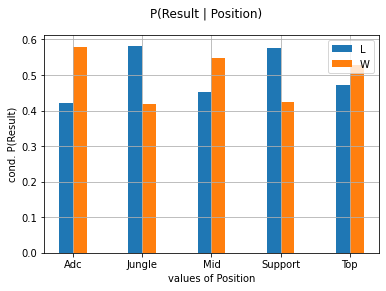

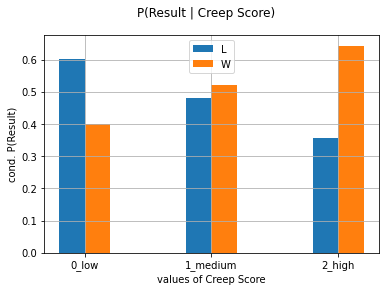

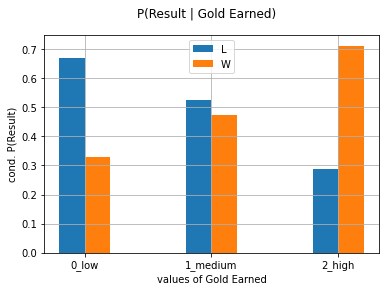

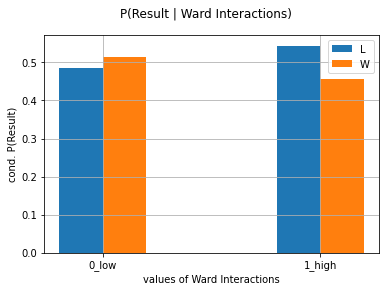

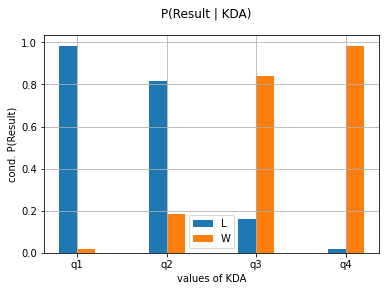

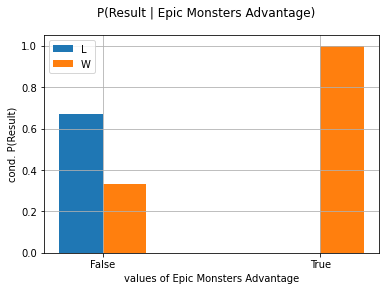

In [14]:
query_var = 'Result'
outcomes = model.get_cpds(node=query_var).state_names[query_var]

for evidence_var in data.columns.drop(query_var).values:
    evidence_vals = np.sort(np.unique(data[evidence_var].values)) # the values of the evidence var
    y = dict()
    for outcome in outcomes:
        y[outcome] = []
    for evidence_val in evidence_vals:
        query = inference.query([query_var], evidence={evidence_var : evidence_val})
        for outcome in outcomes:
            # this try/catch is needed for when a cond. prob. has value 0
            try:
                n = query.name_to_no[query_var][outcome]
                y[outcome].append(query.values[n])
            except: 
                y[outcome].append(0.0)

    print_query_results(query_var, evidence_var, evidence_vals, y)

Comments
- In the case of the query on `Result` it can be seen that stat values that are considered to be positive according to general consensus such as high `KDA` or high `Gold Earned`, indeed correlate with a winning outcome. 
- Each variable though has a different weight on the `W`-`L` scale. `Ward Interactions` influences a little the probability of a win or loss, while having an `Epic Monster Advantage` theoretically guarantees victory.

#### Approximate inference

It is possible to make the same kind of queries with approximate methods based on sampling, as well as producing samples directly.
`pgmpy`’s `ApproxInference` class internally uses
Rejection Sampling/Likelihood Weighting [(go to doc)](https://pgmpy.org/approx_infer/bn_sampling.html?highlight=pgmpy%20sampling%20bayesianmodelsampling#bayesian-model-sampling).

In [15]:
from pgmpy.inference import ApproxInference

inference = ApproxInference(model)
query = inference.query(['Gold Earned'], evidence={'Position' : 'Support'}, n_samples=1000)
print(query)
query = inference.query(['Result'], evidence={'Epic Monsters Advantage' : 'False'}, n_samples=1000)
print(query)

100%|██████████| 1000/1000 [00:00<00:00, 27830.85it/s]


+-----------------------+--------------------+
| Gold Earned           |   phi(Gold Earned) |
+=======================+====================+
| Gold Earned(0_low)    |             0.8100 |
+-----------------------+--------------------+
| Gold Earned(1_medium) |             0.1890 |
+-----------------------+--------------------+
| Gold Earned(2_high)   |             0.0010 |
+-----------------------+--------------------+


100%|██████████| 1000/1000 [00:00<00:00, 83548.54it/s]

+-----------+---------------+
| Result    |   phi(Result) |
+===========+===============+
| Result(L) |        0.6680 |
+-----------+---------------+
| Result(W) |        0.3320 |
+-----------+---------------+


Comments
- Supports usually don't earn much gold during a match and it is reflected in the probability distribution.
- The probability of `Result` | `Epic Monster Advantage = 'False'` is approximately equal to the one computed with Variable Elimination ([go to cell](#another_cell)).

#### Sampling
New data points can be generated according to the joint distribution represented in the Bayesian Network.
Follows an example of sampling using Gibbs sampling (a Markov Chain Monte Carlo method).

In [16]:
from pgmpy.sampling import GibbsSampling
# sampling using Gibbs method. unfortunately the original names of the feature values are lost.
gibbs = GibbsSampling(model)
samples = gibbs.sample(size=1000)
samples.head(10)

d:\Anaconda\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:529: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  warnings.warn(
d:\Anaconda\lib\site-packages\pgmpy\sampling\Sampling.py:433: RuntimeWarning: invalid value encountered in true_divide
  kernel[tup] = prod_cpd_reduced.values / sum(prod_cpd_reduced.values)
  0%|          | 0/999 [00:00<?, ?it/s]d:\Anaconda\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
d:\Anaconda\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  warn(
100%|██████████| 999/999 [00:00<00:00, 4208.71it/s]


,Position,Creep Score,Gold Earned,Ward Interactions,Result,KDA,Epic Monsters Advantage
0,1,1,2,1,0,3,1
1,1,2,2,0,1,2,1
2,2,2,2,0,1,3,0
3,2,2,2,0,1,2,1
4,0,1,1,0,1,3,0
5,1,0,0,0,1,3,0
6,1,0,1,0,1,2,0
7,3,0,1,1,0,1,0
8,3,0,1,1,0,1,0
9,3,0,0,1,0,0,0
